<a href="https://colab.research.google.com/github/yifcats/Capstone_Projects_Tensorflow2/blob/main/Capstone_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish.

In [44]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import numpy as np

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

![Flags overview image](data/germany_uk_flags.png)

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [45]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/drive/MyDrive/Colab Notebooks/data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [46]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

![Model Schematic](data/neural_translation_model.png)

Key:
![Model key](data/neural_translation_model_key.png)

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [47]:
# Spliting into english and german sentences
english_examples =[data.split('\t')[0] for data in data_examples]
german_examples  =[data.split('\t')[1] for data in data_examples]

In [48]:
# Applying the pre processing sentence function
processed_english = [preprocess_sentence(eng_data) for eng_data in english_examples]
processed_german = [preprocess_sentence(ger_data) for ger_data in german_examples]

In [49]:
processed_german = ["<start> "+ sentence + " <end>" for sentence in processed_german]

In [50]:
# Token
def create_tokenizer(list_of_strings):

    tokenization = tf.keras.preprocessing.text.Tokenizer(num_words=None,filters = '',lower=False,char_level=False)
    tokenization.fit_on_texts(list_of_strings)

    return tokenization

# Tokenizing the text
def create_sequence(tokenizer, list_of_strings):

    sentence_seq = tokenizer.texts_to_sequences(list_of_strings)
    return sentence_seq

In [51]:
tokenizer = create_tokenizer(processed_german)
seq_german = create_sequence(tokenizer, processed_german)

In [52]:
num_samples = 5
inx = np.random.choice(len(processed_german), num_samples, replace=False)


print("\n English Processed Data \n")
for i in inx:
    print(processed_english[i])

print("\n German Processed Data and Seqeunce \n")
for i in inx:
    print(processed_german[i], seq_german[i])


 English Processed Data 

can i leave now ?
forget him .
tom might come .
tom is shaving .
i'm not fat .

 German Processed Data and Seqeunce 

<start> kann ich jetzt gehen ? <end> [1, 30, 4, 62, 45, 7, 2]
<start> vergessen sie ihn . <end> [1, 395, 8, 44, 3, 2]
<start> tom kommt vielleicht . <end> [1, 5, 120, 195, 3, 2]
<start> tom rasiert sich . <end> [1, 5, 1775, 34, 3, 2]
<start> ich bin nicht dick ! <end> [1, 4, 15, 12, 447, 9, 2]


In [53]:
# Padding german seqeunce:

def make_padded_dataset(seq_sentence):
    pad_seq = pad_sequences(seq_sentence,maxlen=None,padding='post',value=0)
    return pad_seq

pad_seq_german = make_padded_dataset(seq_german)

## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1. This module has also been made available as a complete saved model in the folder `'./models/tf2-preview_nnlm-en-dim128_1'`.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space.

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [54]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer('/content/drive/MyDrive/Colab Notebooks/models/tf2-preview_nnlm-en-dim128_1',
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [55]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets.
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [56]:
# spliting train and validation
train_data, val_data, train_labels, val_labels = train_test_split(processed_english, pad_seq_german,
                                                                  test_size=0.2)

In [57]:
# creating training and validation datasets
def make_Dataset(input_array, target_array):
    dataset = tf.data.Dataset.from_tensor_slices((input_array,target_array))
    return dataset

def split_sentence(x,y):
    x = tf.strings.split(x,sep=None, maxsplit=-1, name=None)
    return x , y

def embeds_sentence(x,y):
    x = embedding_layer(x)
    return x,y

def fliter_max_length(x,y):
    mask = tf.math.less(tf.cast(tf.shape(x)[0],dtype=tf.int32), 13)
    return mask

def padding(x,y):
    paddings = [[13 - len(x), 0], [0, 0]]
    x = tf.pad(x, paddings)
    return x,y

In [58]:
train_dataset = make_Dataset(train_data, train_labels)
valid_dataset = make_Dataset(val_data, val_labels)

train_dataset = train_dataset.map(split_sentence)
valid_dataset = valid_dataset.map(split_sentence)

train_dataset = train_dataset.map(embeds_sentence)
valid_dataset = valid_dataset.map(embeds_sentence)

train_dataset = train_dataset.filter(fliter_max_length)
valid_dataset = valid_dataset.filter(fliter_max_length)

train_dataset = train_dataset.map(padding)
valid_dataset = valid_dataset.map(padding)

In [59]:
train_dataset = train_dataset.batch(16,drop_remainder= True)
valid_dataset = valid_dataset.batch(16,drop_remainder= True)

In [60]:
print('\n Trainig element Sepc \n')
print(train_dataset.element_spec)

print('\n Validation element Sepc \n')
print(valid_dataset.element_spec)


 Trainig element Sepc 

(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))

 Validation element Sepc 

(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


In [61]:
train_example = iter(train_dataset.take(1))
valid_example = iter(valid_dataset.take(1))

english_example_train , german_example_train = next(train_example)
english_example_valid , german_example_valid = next(valid_example)

In [62]:
# English Shape Example
print(f'English Training Example Shape: {english_example_train.shape}')
print(f'German Validation Example: \n {german_example_valid}')

English Training Example Shape: (16, 13, 128)
German Validation Example: 
 [[   1    4  180   80   12   29  510  661    3    2    0    0    0    0]
 [   1   16   10    5  476  101    7    2    0    0    0    0    0    0]
 [   1    5  681   10   55   47  190   20   91    3    2    0    0    0]
 [   1  229   10  141   19 4349    7    2    0    0    0    0    0    0]
 [   1  760   12   36    3    2    0    0    0    0    0    0    0    0]
 [   1    5  799    3    2    0    0    0    0    0    0    0    0    0]
 [   1    4   51    8   78  827    3    2    0    0    0    0    0    0]
 [   1    5    6 2685    3    2    0    0    0    0    0    0    0    0]
 [   1  453    8   33   36    3    2    0    0    0    0    0    0    0]
 [   1   83    6   47 2881    7    2    0    0    0    0    0    0    0]
 [   1    8   23 1536    3    2    0    0    0    0    0    0    0    0]
 [   1    4   18  394    3    2    0    0    0    0    0    0    0    0]
 [   1    4   18   19 1844   88    3    2    0   

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

![Encoder schematic](data/neural_translation_model_encoder.png)

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence.
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [63]:
from tensorflow.keras.layers import Layer

class EndTokenLayer(Layer):
    def __init__(self , **kwargs):
        super(EndTokenLayer, self).__init__(**kwargs)


    def build(self,inputs):
        self.end_embed = tf.Variable(initial_value=tf.random.uniform(shape=(128,)), trainable=True)


    def call(self, inputs):
        output = tf.tile(tf.reshape(self.end_embed, shape=(1, 1, tf.shape(self.end_embed)[0])),
                         [tf.shape(inputs)[0], 1, 1])

        return tf.keras.layers.concatenate([inputs, output], axis=1)


In [64]:
train_example = iter(train_dataset.take(1))
english_example_train , german_example_train = next(train_example)

In [65]:
temp = EndTokenLayer()(english_example_train)

print(f'Before Shape: {english_example_train.shape}')
print(f'After Shape: {temp.shape}')

Before Shape: (16, 13, 128)
After Shape: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [66]:
def encoder_network_model(input_shape):

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = EndTokenLayer()(inputs)
    x = tf.keras.layers.Masking(mask_value=0)(x)
    output, hidden_state, cell_state  = tf.keras.layers.LSTM(512,return_state=True)(x)

    encoder_model = tf.keras.Model(inputs = inputs , outputs = [hidden_state,cell_state])
    return encoder_model

encode_model = encoder_network_model((13,128))

In [67]:
train_example = iter(train_dataset.take(1))
english_example_train , german_example_train = next(train_example)

print(f"Hidden state: {encode_model(english_example_train)[0].shape}")
print(f"Cell state: {encode_model(english_example_train)[1].shape}")

Hidden state: (16, 512)
Cell state: (16, 512)


In [68]:
encode_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 128)]         0         
                                                                 
 end_token_layer_3 (EndToke  (None, 14, 128)           128       
 nLayer)                                                         
                                                                 
 masking_1 (Masking)         (None, 14, 128)           0         
                                                                 
 lstm_2 (LSTM)               [(None, 512),             1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1312896 (5.01 MB)
Trainable params: 1312896 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

## 5. Build the decoder network
The decoder network follows the schematic diagram below.

![Decoder schematic](data/neural_translation_model_decoder.png)

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [69]:
class Decoder_Network_Model(tf.keras.Model):

    def __init__(self, **kwargs):
        super(Decoder_Network_Model, self).__init__(**kwargs)
        self.unique_vocab_ger = len(tokenizer.index_word) + 1 # total number of unique words german

        # Initilizing Layers
        self.embeded_layer = tf.keras.layers.Embedding(input_dim=self.unique_vocab_ger,output_dim=128, mask_zero = True)
        self.lstm_layer = tf.keras.layers.LSTM(512, return_state=True ,return_sequences=True)
        self.dense_layer = tf.keras.layers.Dense(self.unique_vocab_ger)


    def call(self, inputs, hidden_state = None, cell_state = None):

        x = self.embeded_layer(inputs)

        if (hidden_state is None) and (cell_state is None):
            x, hidden_state_decoder, cell_state_decoder  = self.lstm_layer(x)

        else:
            x, hidden_state_decoder, cell_state_decoder  = self.lstm_layer(x ,initial_state=[hidden_state, cell_state])

        x = self.dense_layer(x)
        return x, hidden_state_decoder, cell_state_decoder

decode_model = Decoder_Network_Model()

In [70]:
train_example = iter(train_dataset.take(1))
english_example_train , german_example_train = next(train_example)

In [71]:
hidden_encoder, cell_encoder = encode_model(english_example_train)
output_decoder, hidden_decoder, cell_decoder = decode_model(german_example_train,hidden_encoder,cell_encoder)

print(f"Output Tensor shape: {output_decoder.shape}")
print(f"Hidden_state Tensor shape: {hidden_decoder.shape}")
print(f"Cell_State Tensor shape: {cell_decoder.shape}")

Output Tensor shape: (16, 14, 5744)
Hidden_state Tensor shape: (16, 512)
Cell_State Tensor shape: (16, 512)


In [72]:
decode_model.summary()

Model: "decoder__network__model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  735232    
                                                                 
 lstm_3 (LSTM)               multiple                  1312768   
                                                                 
 dense_1 (Dense)             multiple                  2946672   
                                                                 
Total params: 4994672 (19.05 MB)
Trainable params: 4994672 (19.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with @tf.function
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [73]:
def german_inputs_outputs(german_batch):

    inputs_decoder = german_batch[:,:-1]
    outputs_decoder = german_batch[:,1:]

    return (inputs_decoder , outputs_decoder)

In [74]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [75]:
@tf.function
def loss_gards(english_input, german_input, german_target):

    with tf.GradientTape() as tape:
        hidden_encoder, cell_encoder = encode_model(english_input)
        output_decoder, _, _ = decode_model(german_input,hidden_encoder,cell_encoder)
        loss_value = loss_obj(german_target,output_decoder)

        trainable_variables = encode_model.trainable_variables + decode_model.trainable_variables
        grads = tape.gradient(loss_value,trainable_variables)
    return loss_value , grads

In [76]:
num_epochs = 15
train_loss_per_epoch = []
validation_loss_per_epoch = []

for i in range(num_epochs):
    loss_batch = []
    loss_val_batch = []

    # For training
    for english, german in train_dataset:
        inputs_decoder , outputs_decoder = german_inputs_outputs(german)
        loss_value , grads = loss_gards(english,inputs_decoder,outputs_decoder)

        # Updating Paramters
        optimizer.apply_gradients(zip(grads,encode_model.trainable_variables + decode_model.trainable_variables))
        loss_batch += [loss_value]

    # for validation
    for english_val, german_val in valid_dataset:
        inputs_decoder_val , outputs_decoder_val = german_inputs_outputs(german_val)
        loss_value_validation , _ = loss_gards(english_val,inputs_decoder_val,outputs_decoder_val)

        loss_val_batch += [loss_value_validation]

    train_loss_per_epoch += [np.mean(loss_batch)]
    validation_loss_per_epoch += [np.mean(loss_val_batch)]

    print(f"Epoch {i}:\t Loss {train_loss_per_epoch[i]}\t Val_Loss {validation_loss_per_epoch[i]}")

Epoch 0:	 Loss 3.067856550216675	 Val_Loss 2.503650665283203
Epoch 1:	 Loss 2.19258975982666	 Val_Loss 2.213712453842163
Epoch 2:	 Loss 1.7592694759368896	 Val_Loss 2.0534307956695557
Epoch 3:	 Loss 1.4161458015441895	 Val_Loss 1.9859966039657593
Epoch 4:	 Loss 1.144106388092041	 Val_Loss 1.9541847705841064
Epoch 5:	 Loss 0.9270951151847839	 Val_Loss 1.9389971494674683
Epoch 6:	 Loss 0.7564195394515991	 Val_Loss 1.9492883682250977
Epoch 7:	 Loss 0.6180147528648376	 Val_Loss 1.9719462394714355
Epoch 8:	 Loss 0.5060502290725708	 Val_Loss 1.9959954023361206
Epoch 9:	 Loss 0.4156944453716278	 Val_Loss 2.021505355834961
Epoch 10:	 Loss 0.3466024696826935	 Val_Loss 2.047130823135376
Epoch 11:	 Loss 0.291782408952713	 Val_Loss 2.06632924079895
Epoch 12:	 Loss 0.2476075440645218	 Val_Loss 2.0969393253326416
Epoch 13:	 Loss 0.21696975827217102	 Val_Loss 2.144029378890991
Epoch 14:	 Loss 0.19202621281147003	 Val_Loss 2.1687304973602295


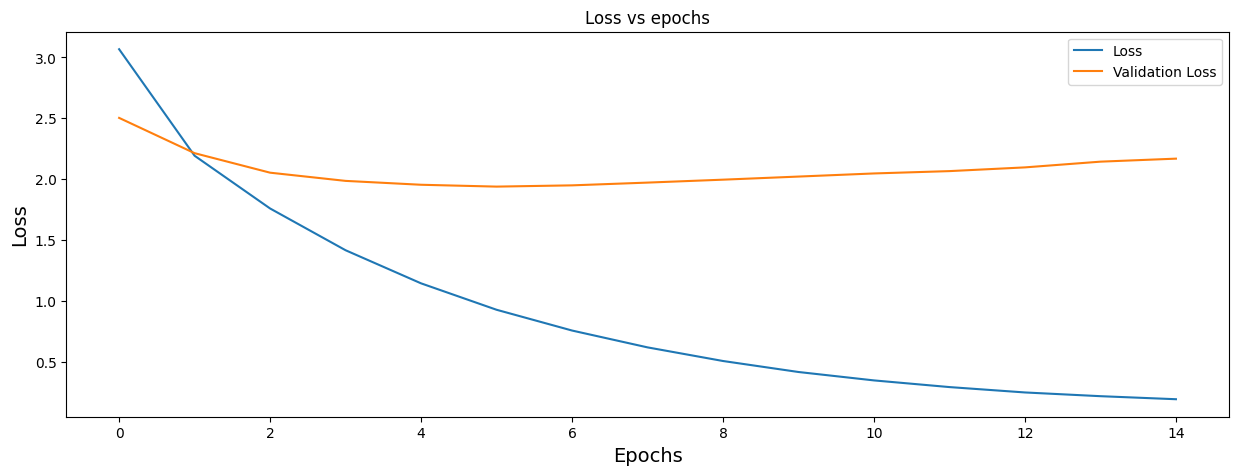

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title('Loss vs epochs')
plt.plot(train_loss_per_epoch)
plt.plot(validation_loss_per_epoch)
plt.legend(['Loss','Validation Loss'])
plt.show()

In [78]:
#encode_model.save('encode_model')
#decode_model.save('decode_model')

In [79]:
#encode_model = tf.keras.models.load_model('encode_model')
#decode_model = tf.keras.models.load_model('decode_model')

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [99]:
 # Random sample index
num_samples = 5
inx = np.random.choice(len(data_examples), num_samples, replace=False)

In [96]:
def process_english(english):
  english = preprocess_sentence(english)
  english = tf.strings.split(english, sep = " ")
  english_em = embedding_layer(english)

  paddings = [[13 - len(english_em), 0], [0, 0]]
  english_em_pad = tf.pad(english_em, paddings)
  english_em_pad = tf.expand_dims(english_em_pad, 0)

  return english_em_pad

In [98]:
# Indicating the start and end token of each example
start_token = tf.Variable([[tokenizer.word_index['<start>']]])
end_token = tf.Variable([[tokenizer.word_index['<end>']]])

# creating a sequence to german word
inv_german_index = {value:key for key,value in tokenizer.word_index.items()}

english_examples =[data.split('\t')[0] for data in data_examples]
german_examples  =[data.split('\t')[1] for data in data_examples]

# Running for all 5 random samples
count = 0
for i in inx:

  count +=1

  test_english_examples = english_examples[i]
  test_german_examples = german_examples[i]

  input_english = process_english(test_english_examples) # creating input for encoder
  hidden_state, cell_state = encode_model(input_english) # passing through encoder

  seq_german_translation = []
  german_translation = []

  # code will run until end token is met
  while True:
    output, hidden_state, cell_state= decode_model(start_token,hidden_state,cell_state)
    output = tf.squeeze(tf.argmax(output, axis=2)).numpy()

    # updating the start token to the output of the decoder
    start_token = tf.Variable([[output]])

    if tf.Variable([[output]]) == end_token:
      break
    else:
      seq_german_translation += [output]

  for seq in seq_german_translation:
    german_translation.append(inv_german_index[seq])

  # printing outputs
  german_translation = " ".join(german_translation)
  print(f"Test English Example\t {count}:\t {test_english_examples} ")
  print(f"German Translation\t {count}:\t {german_translation}")
  print(f"True German Translation\t {count}:\t {test_german_examples}\n")

Test English Example	 1:	 Tell Tom. 
German Translation	 1:	 sag es tom .
True German Translation	 1:	 Sagen Sie es Tom.

Test English Example	 2:	 Tom saw it, too. 
German Translation	 2:	 tom hat das auch gesehen .
True German Translation	 2:	 Tom hat es auch gesehen.

Test English Example	 3:	 Tom looks cross. 
German Translation	 3:	 tom sieht unten .
True German Translation	 3:	 Tom sieht verärgert aus.

Test English Example	 4:	 Neither was true. 
German Translation	 4:	 sie es nicht ?
True German Translation	 4:	 Keines von beiden war wahr.

Test English Example	 5:	 Tom trains dogs. 
German Translation	 5:	 tom studiert .
True German Translation	 5:	 Tom dressiert Hunde.

